# Image Classification with PyTorch and Cleanlab

This quickstart tutorial demonstrates how to find issues in image classification data. Here we use the Fashion-MNIST dataset containing 70,000 images of fashion products from 10 categories, with 7,000 images per category.

**Overview of what we'll do in this tutorial:**

- Build a simple [PyTorch](https://pytorch.org/) neural net.

- Use cross validation to compute out-of-sample predicted probabilities (`pred_probs`) and feature embeddings (`features`).

- Utilize these `pred_probs` and `features` to identify potential issues within the dataset using the `Datalab` class from cleanlab. The issues found by cleanlab include mislabeled examples, near duplicates, outliers, and image-specific problems such as excessively dark or low information images.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have a `model`? Run cross-validation to get out-of-sample `pred_probs` and `features` and then use the code below to find any potential issues in your dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")
lab.find_issues(pred_probs=pred_probs, features=features)

lab.report()
```
    
</div>
</div>

## 1. Install and import required dependencies

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib torch torchvision datasets
!pip install "cleanlab[datalab,image]"
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install "cleanlab[datalab,image] @ git+https://github.com/cleanlab/cleanlab.git"
```

In [1]:
# Package installation (this cell is hidden from docs.cleanlab.ai).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "datasets"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

# Suppress benign warnings: 
import warnings 
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [2]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
import numpy as np

from tqdm.auto import tqdm

from cleanlab import Datalab
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import math

## 2. Fetch and normalize the Fashion-MNIST dataset

In [3]:
dataset_dict = load_dataset("fashion_mnist")

Found cached dataset fashion_mnist (/Users/sanjana/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

View different splits of the dataset

In [4]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
# Combine train and test splits
dataset = concatenate_datasets(list(dataset_dict.values()))

View the number of rows and columns in the dataset

In [6]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70000
})

In [7]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format("torch")


# Apply transformations
def normalize(example):
    example["image"] = (example["image"] / 255.0).unsqueeze(0)
    return example


transformed_dataset = transformed_dataset.map(normalize)

Loading cached processed dataset at /Users/sanjana/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-a234b09061cf1bf9.arrow


<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

Load any huggingface dataset or your local imagefolder dataset, apply relevant transformations, and continue with the rest of the tutorial.

</div>

## 3. Define a classification model
Here, we define a simple neural network with PyTorch.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def embeddings(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [9]:
# This (optional) cell is hidden from docs.cleanlab.ai

SEED = 123  # for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

<details><summary>Helper methods for cross validation **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)

    best_test_accuracy = 0.0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for _, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"].to(device), data["label"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        accuracy = get_test_accuracy(model, testloader)
        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy}"
        )

        running_loss = 0.0

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)
```
</details>

In [10]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)

    best_test_accuracy = 0.0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for _, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"].to(device), data["label"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        accuracy = get_test_accuracy(model, testloader)
        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy}"
        )

        running_loss = 0.0

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)

## 4. Create K folds of the dataset for cross validation

In [11]:
K = 3  # Set to small value here to ensure quick runtimes, we recommend 5 or 10 in practice for more accurate estimates.

kfold = KFold(n_splits=K, shuffle=True, random_state=0)
splits = kfold.split(transformed_dataset)

train_id_list, test_id_list = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

## 5. Compute out-of-sample predicted probabilities and feature embeddings

In [12]:
n_epochs = 3
patience = 2
batch_size = 4

pred_probs_list, embeddings_list = [], []

for i in range(K):
    print(f"Training on fold: {i+1}")

    # Create train and test sets and corresponding dataloaders
    trainset = transformed_dataset.select(train_id_list[i])
    testset = transformed_dataset.select(test_id_list[i])

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Train model
    model = train(trainloader, testloader, n_epochs, patience)

    # Compute out-of-sample embeddings
    print("\nComputing feature embeddings...")
    fold_embeddings = compute_embeddings(model, testloader)
    embeddings_list.append(fold_embeddings)

    print("\nComputing predicted probabilities...")
    # Compute out-of-sample predicted probabilities
    fold_pred_probs = compute_pred_probs(model, testloader)
    pred_probs_list.append(fold_pred_probs)

print("Finished Training")


# Combine embeddings and predicted probabilities from each fold
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()

Training on fold: 1
epoch: 1 loss: 0.775 test acc: 80.67626639238878
epoch: 2 loss: 0.451 test acc: 85.24470729407732
epoch: 3 loss: 0.375 test acc: 86.3932459072598

Computing feature embeddings...


  0%|          | 0/5834 [00:00<?, ?it/s]


Computing predicted probabilities...


  0%|          | 0/5834 [00:00<?, ?it/s]

Training on fold: 2
epoch: 1 loss: 0.779 test acc: 81.0997299961428
epoch: 2 loss: 0.457 test acc: 85.98979985428363
epoch: 3 loss: 0.383 test acc: 86.69695281361162

Computing feature embeddings...


  0%|          | 0/5834 [00:00<?, ?it/s]


Computing predicted probabilities...


  0%|          | 0/5834 [00:00<?, ?it/s]

Training on fold: 3
epoch: 1 loss: 0.761 test acc: 81.95259932284748
epoch: 2 loss: 0.444 test acc: 83.32404748639266
epoch: 3 loss: 0.375 test acc: 85.50979299704281

Computing feature embeddings...


  0%|          | 0/5834 [00:00<?, ?it/s]


Computing predicted probabilities...


  0%|          | 0/5834 [00:00<?, ?it/s]

Finished Training


Reorder rows of the dataset based on row-order in `features` and `pred_probs`

In [13]:
indices = np.hstack(test_id_list)
dataset = dataset.select(indices)

## 7. Use cleanlab to find issues

Based on the given labels, out-of-sample predicted probabilities and feature embeddings, cleanlab can quickly help us detect potential issues in our dataset. 

Here, we use cleanlab's `Datalab` class to find potential issues in our data. `Datalab` has several ways of loading the data. For our current scenario, we are employing the huggingface dataset. `Datalab` takes in two optional arguments, `label_name`, which corresponds to the label column's name, and `image_key`, corresponding to the image column's name.

In [14]:
lab = Datalab(data=dataset, label_name="label", image_key="image")

The `find_issues` method can automatically infer the types of issues to be checked for based on the provided arguments. Here, we provide `features` and `pred_probs` as arguments. If you want to check for a specific issue type, you can do so using the `issue_types` argument. Check the [documentation](https://docs.cleanlab.ai/stable/cleanlab/datalab/datalab.html#cleanlab.datalab.datalab.Datalab.find_issues) for more comprehensive guide on `find_issues` method.

In [15]:
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...


2023-08-23 10:48:01.187570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/70000 [00:00<?, ?it/s]


Audit complete. 94028 issues found in the dataset.


### View report

After the audit is complete, we can view the results and information regarding the issues using `report` method.

Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
       grayscale       70000
 low_information       10775
         outlier        5606
           label        5152
  near_duplicate        2471
            dark          23
         non_iid           1
          blurry           0
           light           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 70000, num_classes: 10


---------------------- outlier issues ----------------------

Number of examples with this issue: 5606
Overall dataset quality in terms of this issue: 0.9870

Examples representing most severe instances of this issue:
       is_outlier_issue  outlier_score
65571              True       0.767257
6547               True       0.800813
52321              True       0.801582
29448              True       0.809940
57834              True       0.810150


----------------------- label issues -----------------------

Numb

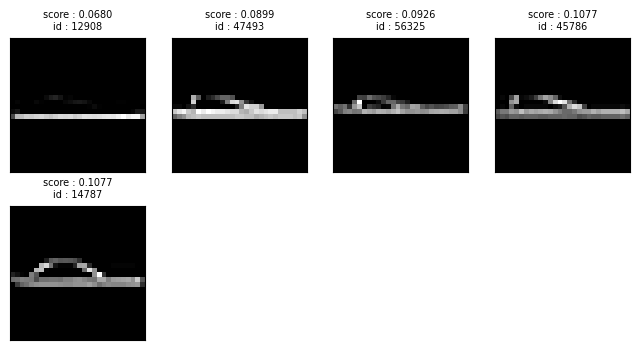

----------------------- dark images ------------------------

Number of examples with this issue: 23
Examples representing most severe instances of this issue:



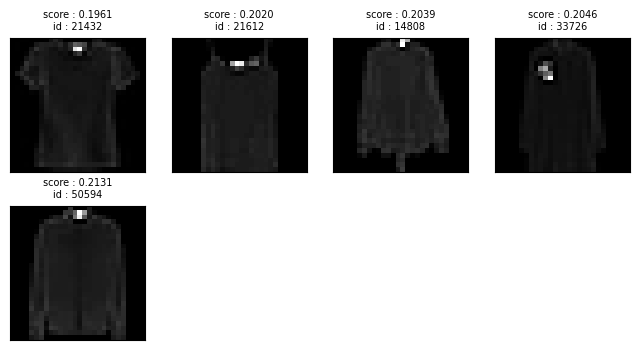

In [16]:
lab.report(include_description=False)

### Label issues

In this section, we focus on visualizing mislabeled examples in the dataset. Label errors occur when the given label for an image is incorrect, usually due to mislabeling during dataset creation. Some of these examples are available at [labelerrors.com](https://labelerrors.com/) under the Caltech-256 dataset.

`get_issues` method returns all the information related to the issue specified. 

In [17]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,False,0.996250,Ankle boot,Ankle boot
1,False,0.181515,Dress,T - shirt / top
2,False,0.989562,Sneaker,Sneaker
3,False,0.687449,Ankle boot,Ankle boot
4,False,0.995221,Sneaker,Sneaker


The above dataframe contains a `label_score` for each example. These numeric scores lie between 0 and 1, where lower scores indicate examples more likely to be mislabeled. It contains a boolean column `is_label_issue` specifying whether or not each example is identified to have a label issue (indicating it is likely mislabeled).

We filter the `label_issues` DataFrame to find examples that are considered to have label errors and sort by `label_score` in ascending order to get the most severe mislabeled examples.

In [18]:
label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
24158,True,0.000001,T - shirt / top,Bag
58039,True,0.000003,Coat,T - shirt / top
55812,True,0.000003,Coat,T - shirt / top
44361,True,0.000005,Bag,Trouser
37395,True,0.000006,Pullover,Dress


<details><summary>See the implementation of `plot_label_issue_examples` **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i  >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.tight_layout(h_pad=2.0)
    plt.show()
```
</details>

In [19]:
def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.tight_layout(h_pad=2.0)
    plt.show()

#### View most likely examples with label errors

Here
`GL` : given label and
`SL` : suggested label by cleanlab

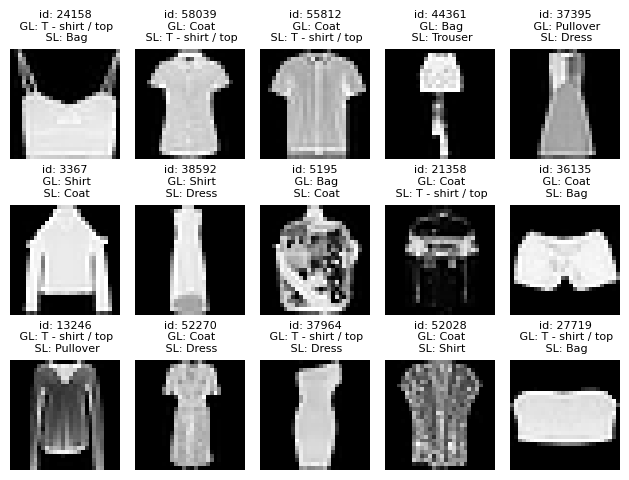

In [20]:
plot_label_issue_examples(label_issues_df, num_examples=15)

### View Outlier issues

In this section, we focus on reviewing atypical examples in the dataset. These are examples that are significantly different from the majority of the dataset, which may have an outsized impact on models fit to this data.

Similarly to the previous section, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers. We then sort the filtered results by their outlier quality score in ascending order, where examples with the lowest scores appear least typical based on the rest of the dataset.

In [21]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df.query("is_outlier_issue").sort_values("outlier_score")
outlier_issues_df.head()

,is_outlier_issue,outlier_score
65571,True,0.767257
6547,True,0.800813
52321,True,0.801582
29448,True,0.809940
57834,True,0.810150


#### View most likely outliers

In this visualization, the first image in every row shows the potential outlier, while the remaining images in the same row depict typical instances from the corresponding class.

<details><summary>See the implementation of `plot_outlier_issues_examples` **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols=4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        image_to_plot = [image] + comparison_images
        fig, axes = plt.subplots(nrows=1, ncols=len(image_to_plot))
        for i, ax in enumerate(axes):
            if i == 0:
                ax.set_title(f"id: {idx}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(image_to_plot[i], cmap="gray")
            ax.axis("off")
        count += 1
        if count >= nrows:
            break
    plt.show()
```
</details>

In [22]:
def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols = 4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        image_to_plot = [image] + comparison_images
        fig, axes = plt.subplots(nrows=1, ncols=len(image_to_plot))
        for i, ax in enumerate(axes):
            if i == 0:
                ax.set_title(f"id: {idx}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(image_to_plot[i], cmap="gray")
            ax.axis("off")
        count += 1
        if count >= nrows:
            break
    plt.show()

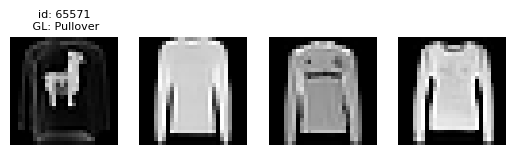

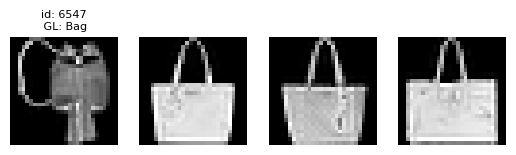

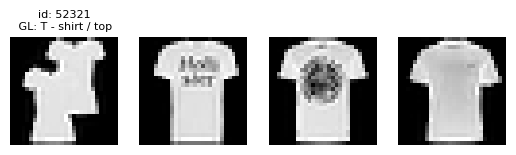

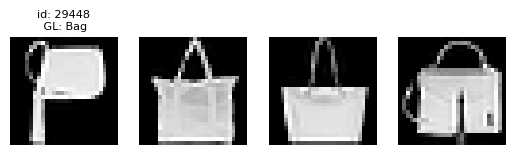

In [23]:
plot_outlier_issues_examples(outlier_issues_df, num_examples=4)

### View near duplicate issues

In this section, we display examples from the dataset that are considered to be nearly duplicated. A lot of near duplicate images in the dataset can lead to model overfitting, It can also impact the accuracy of metrics, subsequently affecting the process of model selection.

The `near_duplicate_issues` DataFrame tells use which examples are considered to have near duplicates, and we can sort them via the `near_duplicate_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue).

This allows us to visualize examples in the dataset that are considered near duplicates, along with their near-duplicate counterparts

In [24]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score"
)
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
53554,True,0.000003,[58806],0.000003
58806,True,0.000003,[53554],0.000003
16842,True,0.000007,[4315],0.000007
4315,True,0.000007,[16842],0.000007
56499,True,0.000010,[53813],0.000010


#### View sets of near duplicate images

<details><summary>See the implementation of `plot_near_duplicate_issue_examples` **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()
```
</details>

In [25]:
def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()

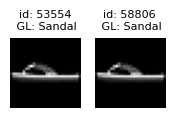

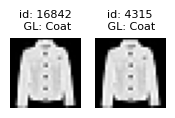

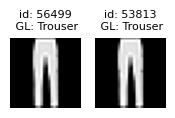

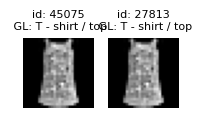

In [26]:
plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=4)

### View dark images

In this section, we display examples from the dataset that are too dark. Sometimes, when the images are too dark, it becomes challenging for both annotators and model to assign
then into one class, leading to poor quality data for training and testing.

The `dark_issues` DataFrame tells use which examples are considered to be too dark, and we can sort them via the `dark_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue). This allows us to visualize examples in the dataset that are considered to be too dark.

In [27]:
dark_issues = lab.get_issues("dark")
dark_issues_df = dark_issues.query("is_dark_issue").sort_values("dark_score")
dark_issues_df.head()

,dark_score,is_dark_issue
21432,0.196078,True
21612,0.202000,True
14808,0.203922,True
33726,0.204588,True
50594,0.213098,True


#### View top examples of dark images

<details><summary>See the implementation of `plot_image_issue_examples` **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_image_issue_examples(issues_df, num_examples=5):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    axes_list = axes.flatten()
    issue_indices = issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i  >= num_examples:
            ax.axis("off")
            continue
        idx = int(issue_indices[i])
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        ax.set_title(
            f"id: {idx}\n GL: {label}\n SL: {predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.tight_layout(h_pad=2.0)
    plt.show()
```
</details>

In [28]:
def plot_image_issue_examples(issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols)
    axes_list = axes.flatten()
    issue_indices = issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(issue_indices[i])
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        ax.set_title(
            f"id: {idx}\n GL: {label}\n SL: {predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.tight_layout(h_pad=2.0)
    plt.show()

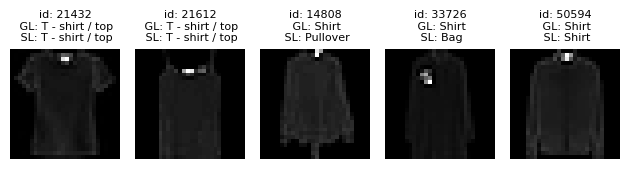

In [29]:
plot_image_issue_examples(dark_issues_df, num_examples=5)

We can see from above examples that too dark images can also lead to label errors as it is difficult to see the contents of the image clearly.

### View low information images

In this section, we display examples from the dataset that are low information. Low information images can impact the quality of the dataset and can also impact the generalizability of the model if they are present disproportionately in one class.

The `lowinfo_issues` DataFrame tells use which examples are considered to be low information, and we can sort them via the `low_information_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue). This allows us to visualize examples in the dataset which are most severe examples of low information issue.

In [30]:
lowinfo_issues = lab.get_issues("low_information")
lowinfo_issues_df = lowinfo_issues.query("is_low_information_issue").sort_values(
    "low_information_score"
)
lowinfo_issues_df.head()

,is_low_information_issue,low_information_score
12908,True,0.067975
47493,True,0.089929
56325,True,0.092601
45786,True,0.107738
14787,True,0.107744


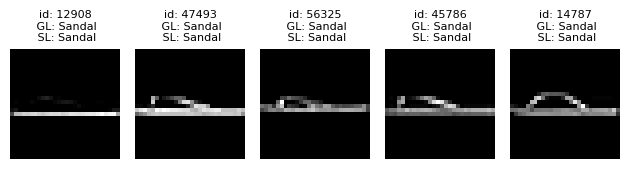

In [31]:
plot_image_issue_examples(lowinfo_issues_df, num_examples=5)

In [32]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

issue_indices = (
    label_issues_df.index.values.tolist()
    + outlier_issues_df.index.values.tolist()
    + near_duplicate_issues_df.index.values.tolist()
    + dark_issues_df.index.values.tolist()
    + lowinfo_issues_df.index.values.tolist()
)
issue_indices = list(set(issue_indices))

# low info, dark, near duplicate, outlier, label in order
highlighted_indices = (
    [12908] + [21432, 21612] + [53554, 58806] + [6547, 52321] + [58039, 55812]
)  # verify these examples were found by cleanlab

if not all(x in issue_indices for x in highlighted_indices):
    raise Exception("Some highlighted examples are missing from ranked_label_issues.")